In [1]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import math
import warnings
warnings.filterwarnings('ignore')

# Dataset dengan Model Boosting dan Bagging
## Penjelasan Metrik Evaluasi

Dalam analisis ini, kita akan menggunakan tiga metrik evaluasi utama untuk menilai performa model:

### 1. Mean Squared Error (MSE)
MSE mengukur rata-rata dari kuadrat kesalahan antara nilai prediksi dan nilai aktual.

**Persamaan Matematika:**
$$ MSE = \frac{Σ(y_i - ŷ_i)^2}{n}$$

Dimana:
- $n$ = jumlah data
- $y_i$ = nilai aktual pada data ke-i
- $ŷ_i$ = nilai prediksi pada data ke-i

**Interpretasi:**
- Nilai MSE selalu positif
- Semakin kecil nilai MSE, semakin baik model dalam melakukan prediksi
- MSE memberikan penalti lebih besar pada kesalahan yang besar karena menggunakan kuadrat

### 2. Root Mean Squared Error (RMSE)
RMSE adalah akar kuadrat dari MSE, yang memberikan nilai error dalam unit yang sama dengan variabel target.

**Persamaan Matematika:**
$$RMSE = \sqrt{MSE} = \sqrt{\frac{Σ(y_i - \hat{y}_i)^2}{n}}$$

**Interpretasi:**
- RMSE memiliki unit yang sama dengan variabel target, sehingga lebih mudah diinterpretasikan
- Semakin kecil nilai RMSE, semakin baik model dalam melakukan prediksi
- Seperti MSE, RMSE juga memberikan penalti lebih pada kesalahan yang besar

### 3. Coefficient of Determination (R²)
R² mengukur proporsi variasi dalam variabel target yang dapat dijelaskan oleh model.

**Persamaan Matematika:**
$$R^2 = 1 - \frac{\sum(y_i - ŷ_i)^2}{ \sum(y_i - ȳ)^2}$$

Dimana:
- $ȳ$ = rata-rata nilai aktual
- Pembilang = Sum of Squares of Residuals (SSR)
- Penyebut = Total Sum of Squares (SST)

**Interpretasi:**
- $R^2$ biasanya bernilai antara 0 dan 1 (dalam kasus tertentu bisa negatif)
- $R^2$ = 1 berarti model dapat menjelaskan semua variabilitas data
- $R^2$ = 0 berarti model tidak dapat menjelaskan variabilitas data sama sekali
- Semakin tinggi nilai R², semakin baik model dalam menjelaskan variasi data

## Penjelasan Model Machine Learning

Dalam analisis ini, kita akan menggunakan beberapa model machine learning dari kelompok Boosting dan Bagging:

### Model Boosting:
Boosting adalah teknik ensemble yang membangun model secara sekuensial dimana setiap model mencoba memperbaiki kesalahan dari model sebelumnya.

#### 1. Gradient Boosting Regressor
Gradient Boosting membangun model secara sekuensial dengan fokus pada residual (kesalahan) dari model sebelumnya. Setiap model baru mencoba untuk memprediksi residual model sebelumnya.

**Algoritma Secara Sederhana:**
1. Inisialisasi model dengan nilai prediksi awal (biasanya rata-rata target)
2. Untuk setiap iterasi:
   - Hitung residual (selisih antara nilai aktual dan prediksi)
   - Latih model baru (biasanya decision tree) untuk memprediksi residual
   - Update prediksi dengan menambahkan hasil prediksi model baru yang telah dikalikan dengan learning rate
3. Gabungkan semua model untuk mendapatkan prediksi akhir

#### 2. AdaBoost Regressor
AdaBoost (Adaptive Boosting) membangun model secara sekuensial dengan memberikan bobot lebih pada data yang salah diprediksi.

**Algoritma Secara Sederhana:**
1. Berikan bobot yang sama untuk semua data
2. Untuk setiap iterasi:
   - Latih model dasar (weak learner)
   - Evaluasi kesalahan dan hitung bobot model
   - Perbarui bobot data (data yang salah diprediksi mendapat bobot lebih besar)
3. Gabungkan semua model dengan bobot masing-masing untuk prediksi akhir

### Model Bagging:

Bagging (Bootstrap Aggregating) adalah teknik ensemble yang membangun beberapa model secara paralel dari sampel data yang berbeda dan menggabungkan hasilnya.

#### 1. Random Forest Regressor
Random Forest adalah ensemble dari decision tree yang dilatih pada sampel bootstrap dari data asli dengan pemilihan fitur acak.

**Algoritma Secara Sederhana:**
1. Untuk setiap tree dalam forest:
   - Ambil sampel bootstrap dari data (sampling dengan pengembalian)
   - Pada setiap node, pilih subset acak dari fitur
   - Latih decision tree dengan data dan fitur yang dipilih
2. Rata-ratakan hasil prediksi dari semua tree untuk mendapatkan prediksi akhir

#### 2. Bagging Regressor
Bagging Regressor secara umum menerapkan teknik bagging pada model dasar apa pun. Dalam analisis ini, kita akan menggunakan Decision Tree sebagai model dasar.

**Algoritma Secara Sederhana:**
1. Untuk setiap estimator:
   - Ambil sampel bootstrap dari data (sampling dengan pengembalian)
   - Latih model dasar dengan sampel data tersebut
2. Rata-ratakan hasil prediksi dari semua estimator untuk mendapatkan prediksi akhir

In [40]:
# Fungsi untuk menghitung metrik evaluasi
def hitung_metrik_evaluasi(y_true, y_pred):
    # Mean Squared Error (MSE)
    # MSE = (1/n) * Σ(yi - ŷi)²
    # dimana yi adalah nilai aktual dan ŷi adalah nilai prediksi
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error (RMSE)
    # RMSE = √MSE = √((1/n) * Σ(yi - ŷi)²)
    rmse = math.sqrt(mse)

    # R² (Coefficient of Determination)
    # R² = 1 - (Σ(yi - ŷi)² / Σ(yi - ȳ)²)
    # dimana ȳ adalah rata-rata nilai aktual
    r2 = r2_score(y_true, y_pred)

    return {
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# Fungsi untuk menampilkan hasil evaluasi model
def tampilkan_evaluasi(model_results, title):
    # Konversi hasil ke DataFrame untuk tampilan yang lebih baik
    results_df = pd.DataFrame(model_results).T

    # Menampilkan hasil dalam bentuk tabel
    print(f"=== Hasil Evaluasi Model untuk {title} ===")
    print(results_df)
    print("\n")

    # Visualisasi hasil
    plt.figure(figsize=(12, 6))

    # RMSE (lebih kecil lebih baik)
    plt.subplot(1, 3, 1)
    sns.barplot(x=results_df.index, y='RMSE', data=results_df)
    plt.title('RMSE (Root Mean Squared Error)')
    plt.xlabel('Model')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)

    # MSE (lebih kecil lebih baik)
    plt.subplot(1, 3, 2)
    sns.barplot(x=results_df.index, y='MSE', data=results_df)
    plt.title('MSE (Mean Squared Error)')
    plt.xlabel('Model')
    plt.ylabel('MSE')
    plt.xticks(rotation=45)

    # R² (lebih besar lebih baik)
    plt.subplot(1, 3, 3)
    sns.barplot(x=results_df.index, y='R²', data=results_df)
    plt.title('R² (R Squared)')
    plt.xlabel('Model')
    plt.ylabel('R²')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

# Implementasi pada Dataset
## Dataset 1: Automobile
### 1. Memuat dan Menyiapkan Data

In [41]:
df_automobile = pd.read_csv('Automobile.csv')
print('deskripsikan tiap kolom:')
display(df_automobile.describe())
print('\ninfo tiap kolom:')
display(df_automobile.info())
print('\nisi tiap kolom:')
display(df_automobile.head())

deskripsikan tiap kolom:


,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,engine-size,num-of-cylinders,curb-weight,height,width,length,wheel-base,num-of-doors,normalized-losses,symboling
count,201.000000,205.000000,205.000000,203.000000,203.000000,205.000000,201.000000,201.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,203.000000,164.000000,205.000000
mean,13207.129353,30.751220,25.219512,5125.369458,104.256158,10.142537,3.255423,3.329751,126.907317,4.380488,2555.565854,53.724878,65.907805,174.049268,98.756585,3.123153,122.000000,0.834146
std,7947.066342,6.886443,6.542142,479.334560,39.714369,3.972040,0.316717,0.273539,41.642693,1.080854,520.680204,2.443522,2.145204,12.337289,6.021776,0.994841,35.442168,1.245307
min,5118.000000,16.000000,13.000000,4150.000000,48.000000,7.000000,2.070000,2.540000,61.000000,2.000000,1488.000000,47.800000,60.300000,141.100000,86.600000,2.000000,65.000000,-2.000000
25%,7775.000000,25.000000,19.000000,4800.000000,70.000000,8.600000,3.110000,3.150000,97.000000,4.000000,2145.000000,52.000000,64.100000,166.300000,94.500000,2.000000,94.000000,0.000000
50%,10295.000000,30.000000,24.000000,5200.000000,95.000000,9.000000,3.290000,3.310000,120.000000,4.000000,2414.000000,54.100000,65.500000,173.200000,97.000000,4.000000,115.000000,1.000000
75%,16500.000000,34.000000,30.000000,5500.000000,116.000000,9.400000,3.410000,3.590000,141.000000,4.000000,2935.000000,55.500000,66.900000,183.100000,102.400000,4.000000,150.000000,2.000000
max,45400.000000,54.000000,49.000000,6600.000000,288.000000,23.000000,4.170000,3.940000,326.000000,12.000000,4066.000000,59.800000,72.300000,208.100000,120.900000,4.000000,256.000000,3.000000



info tiap kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              201 non-null    float64
 1   highway-mpg        205 non-null    int64  
 2   city-mpg           205 non-null    int64  
 3   peak-rpm           203 non-null    float64
 4   horsepower         203 non-null    float64
 5   compression-ratio  205 non-null    float64
 6   stroke             201 non-null    float64
 7   bore               201 non-null    float64
 8   fuel-system        205 non-null    object 
 9   engine-size        205 non-null    int64  
 10  num-of-cylinders   205 non-null    int64  
 11  engine-type        205 non-null    object 
 12  curb-weight        205 non-null    int64  
 13  height             205 non-null    float64
 14  width              205 non-null    float64
 15  length             205 non-null    float64
 16  wheel-ba

None


isi tiap kolom:


,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,...,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses,symboling
0,13495.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN,3
1,16500.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN,3
2,16500.0,26,19,5000.0,154.0,9.0,3.47,2.68,mpfi,152,...,94.5,front,rwd,hatchback,2.0,std,gas,alfa-romero,NaN,1
3,13950.0,30,24,5500.0,102.0,10.0,3.40,3.19,mpfi,109,...,99.8,front,fwd,sedan,4.0,std,gas,audi,164.0,2
4,17450.0,22,18,5500.0,115.0,8.0,3.40,3.19,mpfi,136,...,99.4,front,4wd,sedan,4.0,std,gas,audi,164.0,2


### 2. Pra-pemrosesan Data

In [42]:
# Bersihkan data
df_automobile.dropna(inplace=True)

# Pilih target
target = 'price'
X = df_automobile.drop(target, axis=1)
y = df_automobile[target]

# Identifikasi kolom numerik dan kategorikal
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Kolom numerik: {len(numeric_cols)}")
print(f"Kolom kategorikal: {len(categorical_cols)}")

# Preprocessing untuk kolom numerik dan kategorikal
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nJumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")

Kolom numerik: 17
Kolom kategorikal: 8

Jumlah data training: 127
Jumlah data testing: 32


### 3. Membangun dan Mengevaluasi Model

Melatih model Linear Regression...
Selesai melatih model Linear Regression
Melatih model Gradient Boosting...
Selesai melatih model Gradient Boosting
Melatih model AdaBoost...
Selesai melatih model AdaBoost
Melatih model Random Forest...
Selesai melatih model Random Forest
Melatih model Bagging...
Selesai melatih model Bagging
=== Hasil Evaluasi Model untuk Dataset Automobile ===
                            MSE         RMSE        R²
Linear Regression  3.187491e+06  1785.354548  0.820873
Gradient Boosting  3.294334e+06  1815.029976  0.814869
AdaBoost           2.838066e+06  1684.656093  0.840510
Random Forest      2.912561e+06  1706.622550  0.836324
Bagging            2.977004e+06  1725.399728  0.832702




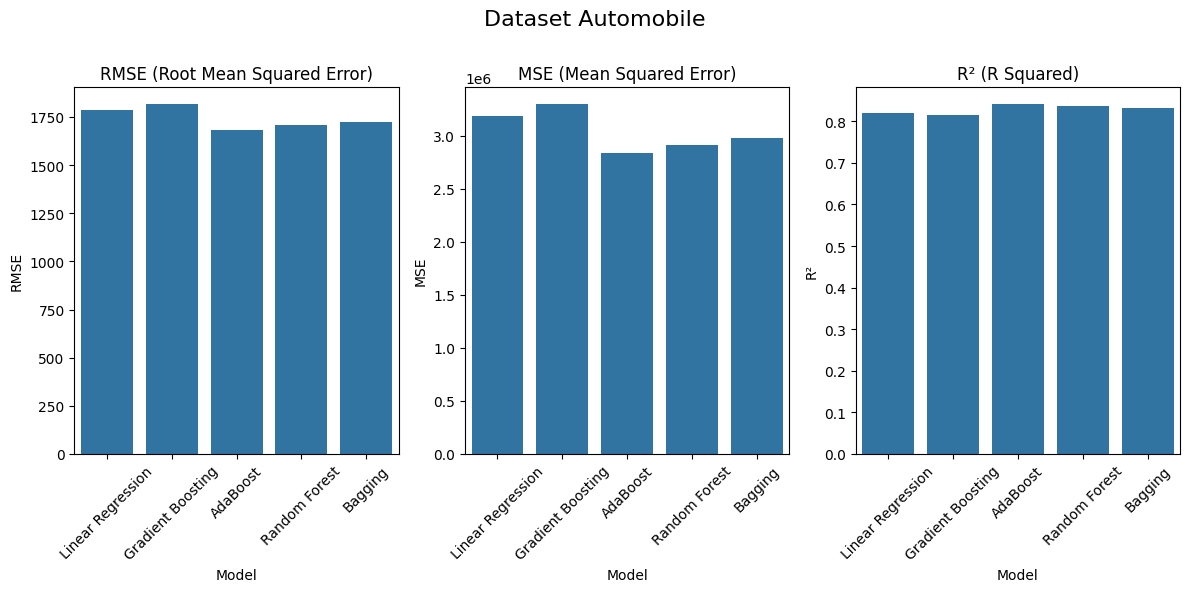

In [43]:
# Model dasar untuk perbandingan
base_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

# Model Boosting
gb_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))])

ada_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', AdaBoostRegressor(n_estimators=100, random_state=42))])

# Model Bagging
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

bag_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', BaggingRegressor(estimator=DecisionTreeRegressor(),
                                                           n_estimators=100, random_state=42))])

# Daftar model yang akan dievaluasi
models = {
    'Linear Regression': base_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ada_model,
    'Random Forest': rf_model,
    'Bagging': bag_model
}

# Dictionary untuk menyimpan hasil evaluasi
auto_results = {}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"Melatih model {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Hitung metrik evaluasi
    auto_results[name] = hitung_metrik_evaluasi(y_test, y_pred)

    print(f"Selesai melatih model {name}")

# Tampilkan hasil evaluasi
tampilkan_evaluasi(auto_results, "Dataset Automobile")

### Analisis Hasil
1. AdaBoost merupakan model terbaik untuk dataset Automobile ini, menghasilkan prediksi paling akurat dan menjelaskan variansi data paling baik.
2. Teknik ensemble (AdaBoost, Random Forest, Bagging) secara umum berkinerja lebih baik dibandingkan model tunggal (Linear Regression).
3. Gradient Boosting justru memiliki performa paling rendah di antara semua model, menunjukkan bahwa parameter atau konfigurasi yang digunakan mungkin belum optimal untuk dataset ini.
4. Semua model memiliki nilai R² di atas 0.81, mengindikasikan bahwa semuanya cukup baik dalam menjelaskan variansi dalam dataset, meskipun ada perbedaan performa.

## Dataset 2: Boston Housing
### 1. Memuat dan Menyiapkan Data

In [44]:
df_boston = pd.read_csv('HousingData.csv')
print('deskripsikan tiap kolom:')
display(df_boston.describe())
print('\ninfo tiap kolom:')
display(df_boston.info())
print('\nisi tiap kolom:')
display(df_boston.head())

deskripsikan tiap kolom:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000



info tiap kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


None


isi tiap kolom:


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


### 2. Pra-pemrosesan Data

In [47]:
# Pilih target
target = 'MEDV'
X = df_boston.drop(target, axis=1)
y = df_boston[target]

# Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing untuk kolom numerik
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.columns)
    ])

print(f"\nJumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")


Jumlah data training: 404
Jumlah data testing: 102


### 3. Membangun dan Mengevaluasi Model

Melatih model Linear Regression...
Selesai melatih model Linear Regression
Melatih model Gradient Boosting...
Selesai melatih model Gradient Boosting
Melatih model AdaBoost...
Selesai melatih model AdaBoost
Melatih model Random Forest...
Selesai melatih model Random Forest
Melatih model Bagging...
Selesai melatih model Bagging
=== Hasil Evaluasi Model untuk Dataset Boston Housing ===
                         MSE      RMSE        R²
Linear Regression  24.983445  4.998344  0.659319
Gradient Boosting   7.302793  2.702368  0.900417
AdaBoost           10.643847  3.262491  0.854858
Random Forest       8.163188  2.857129  0.888684
Bagging             8.277956  2.877144  0.887119




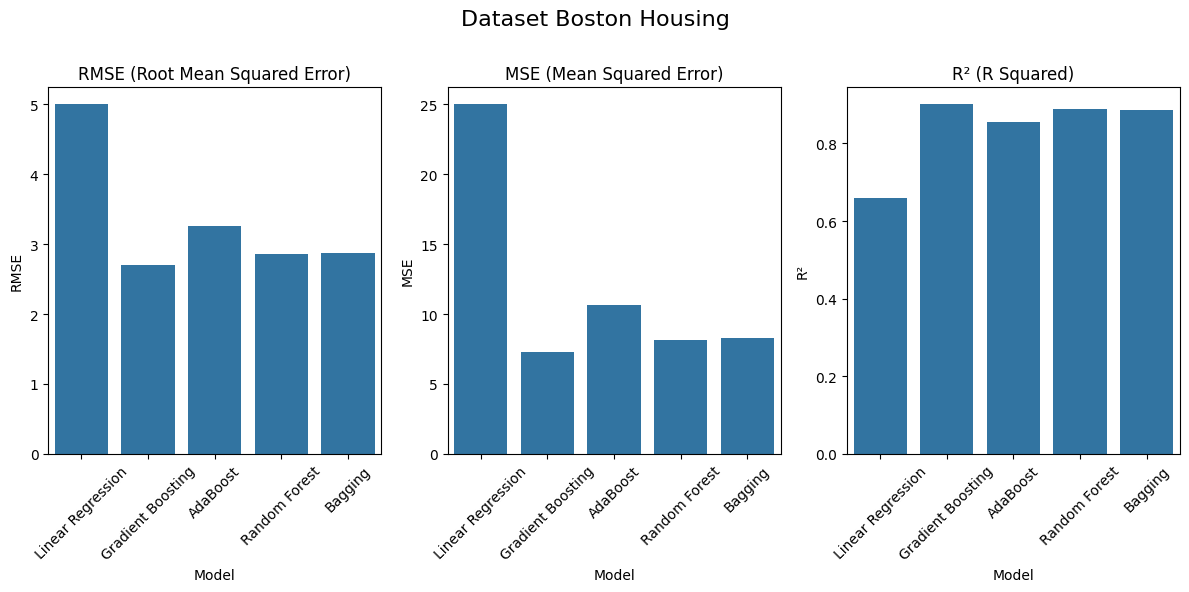

In [49]:
# Model dasar untuk perbandingan
base_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

# Model Boosting
gb_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))])

ada_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', AdaBoostRegressor(n_estimators=100, random_state=42))])

# Model Bagging
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

bag_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', BaggingRegressor(estimator=DecisionTreeRegressor(),
                                                           n_estimators=100, random_state=42))])

# Daftar model yang akan dievaluasi
models = {
    'Linear Regression': base_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ada_model,
    'Random Forest': rf_model,
    'Bagging': bag_model
}

# Dictionary untuk menyimpan hasil evaluasi
boston_results = {}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"Melatih model {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Hitung metrik evaluasi
    boston_results[name] = hitung_metrik_evaluasi(y_test, y_pred)

    print(f"Selesai melatih model {name}")

# Tampilkan hasil evaluasi
tampilkan_evaluasi(boston_results, "Dataset Boston Housing")

### Analisis Hasil
1. Gradient Boosting merupakan model terbaik untuk dataset Boston Housing, mengungguli semua model lainnya dengan margin yang cukup signifikan.
2. Teknik ensemble (Gradient Boosting, Random Forest, Bagging, AdaBoost) secara konsisten mengungguli model tunggal (Linear Regression).
3. Linear Regression memiliki performa jauh di bawah model lainnya, menunjukkan bahwa dataset Boston Housing mungkin memiliki hubungan non-linear yang signifikan antara fitur dan target.
4. Perbedaan performa antara Gradient Boosting dan Linear Regression sangat substansial (nilai R² 0.90 vs 0.66), mengindikasikan bahwa pemilihan algoritma yang tepat sangat penting untuk dataset ini.
5. Random Forest dan Bagging menunjukkan performa yang hampir identik, menunjukkan karakteristik dataset yang responsive terhadap teknik ensemble berbasis tree.

## Dataset 3: Infrared
### 1. Memuat dan Menyiapkan Data

In [50]:
df_infrared = pd.read_csv('Infrared.csv')
print('deskripsikan tiap kolom:')
display(df_infrared.describe())
print('\ninfo tiap kolom:')
display(df_infrared.info())
print('\nisi tiap kolom:')
display(df_infrared.head())

deskripsikan tiap kolom:


,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,...,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,aveOralM
count,1020.000000,1020.000000,1018.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,...,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000,1020.000000
mean,24.115392,28.723039,0.729784,0.968648,35.596533,35.611474,34.888475,35.011345,35.659921,35.587143,...,34.567782,34.565340,34.487701,34.577293,35.421555,35.094144,36.084785,35.805519,35.838277,37.028382
std,1.336338,13.071627,2.456486,0.362587,0.574888,0.549760,0.718613,0.633836,0.553897,0.569278,...,0.669410,0.678663,0.668065,0.728678,0.523477,0.576045,0.491821,0.559258,0.559316,0.509502
min,20.200000,9.900000,0.540000,-0.590000,33.897500,34.122500,31.770000,32.902500,33.985000,33.825000,...,31.452500,31.657500,31.280000,31.150000,33.407500,32.440000,34.892500,33.802500,33.835000,35.540000
25%,23.400000,17.600000,0.600000,0.772500,35.247500,35.271875,34.456250,34.651250,35.332500,35.249375,...,34.180000,34.177500,34.096875,34.225000,35.116875,34.756458,35.775000,35.474375,35.500000,36.777500
50%,24.000000,26.300000,0.620000,0.940000,35.548750,35.575000,34.915000,34.997500,35.602500,35.533750,...,34.597500,34.602500,34.512917,34.622500,35.391250,35.100000,36.027500,35.790000,35.825000,36.940000
75%,24.700000,36.200000,0.700000,1.140000,35.872500,35.883125,35.300000,35.363125,35.910625,35.855625,...,34.968125,34.965000,34.878125,35.012500,35.675000,35.415000,36.280000,36.087500,36.120625,37.140000
max,29.100000,61.200000,79.000000,2.875000,38.405000,38.042500,37.575000,37.680000,38.385000,38.380000,...,37.075000,37.165000,37.212500,37.367500,38.002500,37.632500,38.807500,38.417500,38.455000,40.340000



info tiap kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 34 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Gender       1020 non-null   object 
 1   Age          1020 non-null   object 
 2   Ethnicity    1020 non-null   object 
 3   T_atm        1020 non-null   float64
 4   Humidity     1020 non-null   float64
 5   Distance     1018 non-null   float64
 6   T_offset1    1020 non-null   float64
 7   Max1R13_1    1020 non-null   float64
 8   Max1L13_1    1020 non-null   float64
 9   aveAllR13_1  1020 non-null   float64
 10  aveAllL13_1  1020 non-null   float64
 11  T_RC1        1020 non-null   float64
 12  T_RC_Dry1    1020 non-null   float64
 13  T_RC_Wet1    1020 non-null   float64
 14  T_RC_Max1    1020 non-null   float64
 15  T_LC1        1020 non-null   float64
 16  T_LC_Dry1    1020 non-null   float64
 17  T_LC_Wet1    1020 non-null   float64
 18  T_LC_Max1    1020 non-null   f

None


isi tiap kolom:


,Gender,Age,Ethnicity,T_atm,Humidity,Distance,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,...,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,aveOralM
0,Male,41-50,White,24.0,28.0,0.8,0.7025,35.0300,35.3775,34.4000,...,33.4775,33.3725,33.4925,33.0025,34.5300,34.0075,35.6925,35.6350,35.6525,36.59
1,Female,31-40,Black or African-American,24.0,26.0,0.8,0.7800,34.5500,34.5200,33.9300,...,34.0550,33.6775,33.9700,34.0025,34.6825,34.6600,35.1750,35.0925,35.1075,37.19
2,Female,21-30,White,24.0,26.0,0.8,0.8625,35.6525,35.5175,34.2775,...,34.8275,34.6475,34.8200,34.6700,35.3450,35.2225,35.9125,35.8600,35.8850,37.34
3,Female,21-30,Black or African-American,24.0,27.0,0.8,0.9300,35.2225,35.6125,34.3850,...,34.4225,34.6550,34.3025,34.9175,35.6025,35.3150,35.7200,34.9650,34.9825,37.09
4,Male,18-20,White,24.0,27.0,0.8,0.8950,35.5450,35.6650,34.9100,...,35.1600,34.3975,34.6700,33.8275,35.4175,35.3725,35.8950,35.5875,35.6175,37.04


### 2. Pra-pemrosesan Data

In [52]:
# Pilih target
target = 'aveOralM'
X = df_infrared.drop(target, axis=1)
y = df_infrared[target]

# Identifikasi kolom numerik dan kategorikal
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Kolom numerik: {len(numeric_cols)}")
print(f"Kolom kategorikal: {len(categorical_cols)}")

# Preprocessing untuk kolom numerik dan kategorikal
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Pisahkan data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nJumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")

Kolom numerik: 30
Kolom kategorikal: 3

Jumlah data training: 816
Jumlah data testing: 204


### 3. Membangun dan Mengevaluasi Model

Melatih model Linear Regression...
Selesai melatih model Linear Regression
Melatih model Gradient Boosting...
Selesai melatih model Gradient Boosting
Melatih model AdaBoost...
Selesai melatih model AdaBoost
Melatih model Random Forest...
Selesai melatih model Random Forest
Melatih model Bagging...
Selesai melatih model Bagging
=== Hasil Evaluasi Model untuk Dataset Infrared ===
                        MSE      RMSE        R²
Linear Regression  0.054048  0.232482  0.743328
Gradient Boosting  0.050137  0.223913  0.761901
AdaBoost           0.059669  0.244273  0.716632
Random Forest      0.056968  0.238679  0.729463
Bagging            0.057135  0.239030  0.728667




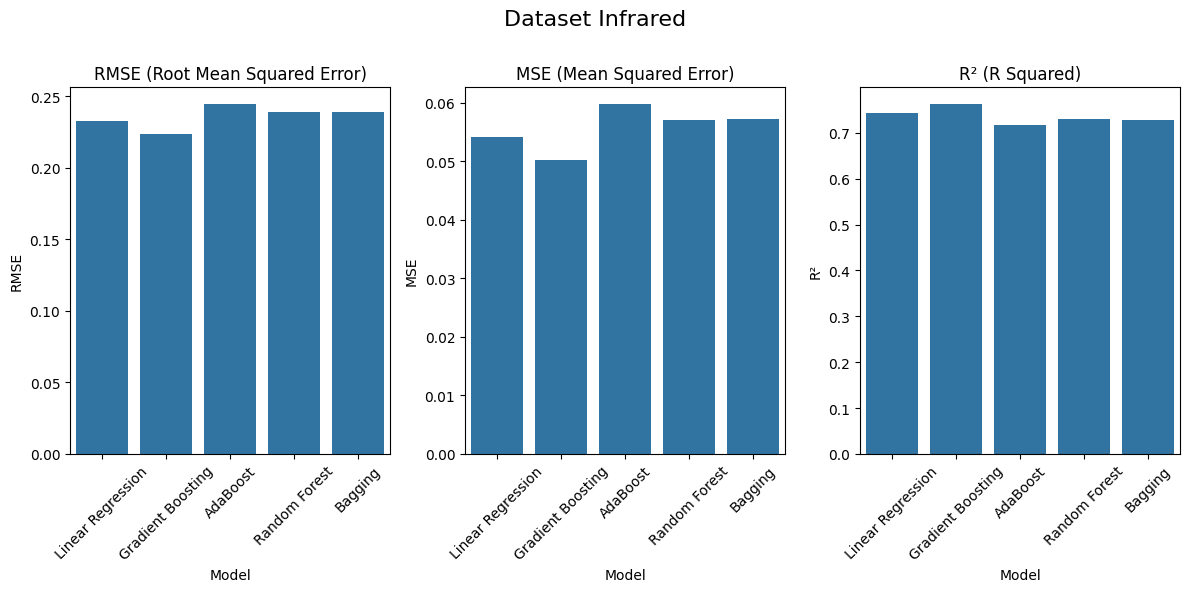

In [54]:
# Model dasar untuk perbandingan
base_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', LinearRegression())])

# Model Boosting
gb_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))])

ada_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', AdaBoostRegressor(n_estimators=100, random_state=42))])

# Model Bagging
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

bag_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', BaggingRegressor(estimator=DecisionTreeRegressor(),
                                                           n_estimators=100, random_state=42))])

# Daftar model yang akan dievaluasi
models = {
    'Linear Regression': base_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ada_model,
    'Random Forest': rf_model,
    'Bagging': bag_model
}

# Dictionary untuk menyimpan hasil evaluasi
boston_results = {}

# Latih dan evaluasi setiap model
for name, model in models.items():
    print(f"Melatih model {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Hitung metrik evaluasi
    boston_results[name] = hitung_metrik_evaluasi(y_test, y_pred)

    print(f"Selesai melatih model {name}")

# Tampilkan hasil evaluasi
tampilkan_evaluasi(boston_results, "Dataset Infrared")

### Analisis Hasil
1. Gradient Boosting menunjukkan performa terbaik untuk dataset ini, meskipun keunggulannya tidak terlalu jauh dibandingkan model lain.
2. Menariknya, Linear Regression berada di peringkat kedua, mengungguli beberapa teknik ensemble yang lebih kompleks (Random Forest, Bagging, dan AdaBoost).
3. Perbedaan performa antar model relatif kecil (nilai R² berkisar antara 0.716 dan 0.762), mengindikasikan bahwa semua model mampu memodelkan dataset dengan tingkat keberhasilan yang serupa.
4. AdaBoost justru menunjukkan performa terburuk, berbeda dengan dataset-dataset lain di mana biasanya Linear Regression yang terburuk.
5. Random Forest dan Bagging menunjukkan performa yang hampir identik, dengan selisih nilai metrik yang sangat kecil.
6. Secara umum, nilai MSE sangat rendah (sekitar 0.05) untuk semua model, menunjukkan bahwa dataset Infrared ini mungkin lebih mudah dimodelkan dibandingkan dataset sebelumnya atau telah melalui transformasi/normalisasi tertentu.